In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.datasets import fashion_mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape)
from keras.layers import LeakyReLU
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

This code imports necessary libraries/modules for building and training a GAN on the Fashion MNIST dataset using Keras.

In [ ]:
class Dataset:

    def __init__(self, num_labeled):

        self.num_labeled = num_labeled
        (self.x_train, self.y_train), (self.x_test,
                                       self.y_test) =fashion_mnist.load_data()
        def preprocess_imgs(x):
            x = (x.astype(np.float32) - 127.5) / 127.5
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)

        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

 prepares and provides datasets (labeled and unlabeled) for training a model,  with preprocessing methods for images and labels.




In [ ]:
num_labeled = 100
dataset = Dataset(num_labeled)

creates an instance of the Dataset class initialized with 100 labeled examples from the Fashion MNIST dataset.

In [ ]:
(x_train,y_train), (x_test,y_test) =fashion_mnist.load_data()

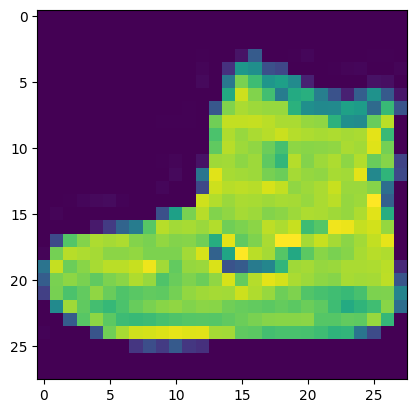

In [ ]:
plt.imshow(xtrain[0])

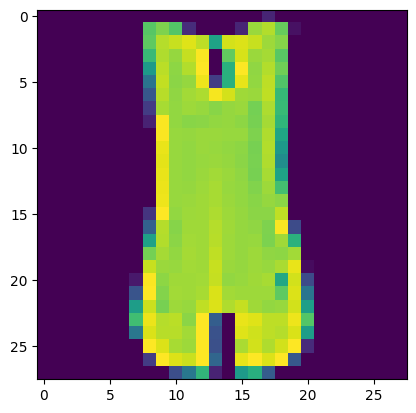

In [ ]:
plt.imshow(xtrain[4])

In [ ]:
x_test,y_test=dataset.test_set()

In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100
num_classes = 10

Defines image dimensions (28x28x1), latent space dimension (100), and number of classes (10) for a GAN model trained on the dataset.

In [ ]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))

    return model

 Dense layer to map the input latent space (z_dim) to a higher-dimensional representation.
then reshaping this representation into a 7x7x256 feature map then using multiple Conv2DTranspose layers to upsample the features, followed by BatchNormalization and LeakyReLU activation to generate synthetic images in the form of 28x28x1 pixels with values in the range [-1, 1] using tanh activation.

In [ ]:
def build_discriminator_net(img_shape):
    model = Sequential()
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(num_classes))
    return model

This function defines a convolutional neural network discriminator model in Keras for a GAN, tailored to the input image shape  with multiple convolutional layers, batch normalization, dropout for regularization, and a final dense layer outputting logits for classification into num_classes categories.

In [ ]:
def build_discriminator_supervised(discriminator_net):
    model = Sequential()
    model.add(discriminator_net)
    model.add(Activation('softmax'))
    return model

In [ ]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):

        prediction = 1.0 - (1.0 /
                            (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))

        return prediction

    model.add(Lambda(predict))

    return model

This function constructs an unsupervised discriminator model using a pre-defined discriminator_net by adding a custom Lambda layer that applies a sigmoid-like function (1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))) to the output of discriminator_net.





In [ ]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
def baseline_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    return model
model = baseline_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 1600)              0         
                                                                 
 dense_25 (Dense)            (None, 128)             

defines a baseline convolutional neural network  model compiles it with the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric, and prints a summary of the model architecture.




In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Baseline Model - Accuracy: {accuracy:.4f}')

Epoch 1/10
469/469 [==============================] - 57s 116ms/step - loss: 0.9982 - accuracy: 0.7471 - val_loss: 0.4242 - val_accuracy: 0.8396
Epoch 2/10
469/469 [==============================] - 53s 113ms/step - loss: 0.4514 - accuracy: 0.8388 - val_loss: 0.3712 - val_accuracy: 0.8623
Epoch 3/10
469/469 [==============================] - 51s 108ms/step - loss: 0.3909 - accuracy: 0.8578 - val_loss: 0.3467 - val_accuracy: 0.8734
Epoch 4/10
469/469 [==============================] - 49s 105ms/step - loss: 0.3528 - accuracy: 0.8706 - val_loss: 0.3240 - val_accuracy: 0.8786
Epoch 5/10
469/469 [==============================] - 51s 108ms/step - loss: 0.3343 - accuracy: 0.8768 - val_loss: 0.3154 - val_accuracy: 0.8829
Epoch 6/10
469/469 [==============================] - 49s 105ms/step - loss: 0.3134 - accuracy: 0.8839 - val_loss: 0.3201 - val_accuracy: 0.8845
Epoch 7/10
469/469 [==============================] - 54s 115ms/step - loss: 0.2976 - accuracy: 0.8894 - val_loss: 0.3092 - val_ac

In [ ]:
discriminator_net = build_discriminator_net(img_shape)
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer=Adam())
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                   optimizer=Adam())

This code builds two discriminator models: discriminator_supervised for supervised learning with categorical crossentropy loss and accuracy metric, and discriminator_unsupervised for unsupervised learning with binary crossentropy loss, both compiled using the Adam optimizer.




In [ ]:
generator = build_generator(z_dim)
discriminator_unsupervised.trainable = False
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
supervised_losses = []
iteration_checkpoints = []
def train(iterations, batch_size, sample_interval):

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        imgs, labels = dataset.batch_labeled(batch_size)
        labels = to_categorical(labels, num_classes=num_classes)
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)
        d_loss_real = discriminator_unsupervised.train_on_batch(
            imgs_unlabeled, real)
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)
        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))
        if (iteration + 1) % sample_interval == 0:
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))

This function trains a GAN model iteratively for a specified number of iterations  updating the discriminator and generator  models based on batched labeled and unlabeled data, printing losses and accuracies at specified intervals

In [ ]:
iterations = 1000
batch_size = 32
sample_interval = 100
train(iterations, batch_size, sample_interval)

1/1 [==============================] - 0s 86ms/step
100 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0001] [G loss: 0.000159]
1/1 [==============================] - 0s 195ms/step
200 [D loss supervised: 0.0006, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000003]
1/1 [==============================] - 0s 84ms/step
300 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000030]
1/1 [==============================] - 0s 87ms/step
400 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000056]
1/1 [==============================] - 0s 122ms/step
500 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000023]
1/1 [==============================] - 0s 88ms/step
600 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0001] [G loss: 0.000026]
1/1 [==============================] - 0s 162ms/step
700 [D loss supervised: 0.0002, acc.: 100.00%] [D loss un

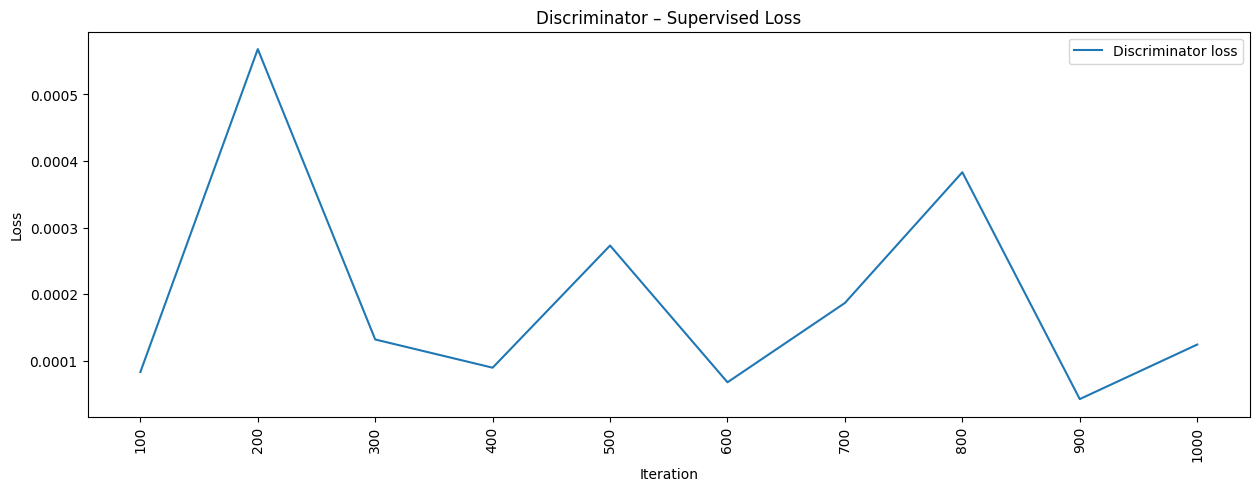

In [ ]:
losses = np.array(supervised_losses)
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

The purpose of this graph is to provide a visual representation of the discriminator's performance during the supervised training phase model's performance.
The discriminator loss starts low, then spikes up around iteration 200, indicating the model is struggling at this point.The loss then decreases and exhibits a more stable pattern between iterations 300-600, suggesting the model is learning effectively Another spike in loss occurs around iteration 700, followed by a gradual decline towards the end of the training process.

In [ ]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 7ms/step - loss: 0.0081 - accuracy: 1.0000
Training Accuracy: 100.00%



This code evaluates the training accuracy of the supervised discriminator model on the labeled training set

In [ ]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 4s 11ms/step - loss: 1.9137 - accuracy: 0.6697
Test Accuracy: 66.97%


This code evaluates the test accuracy of the supervised discriminator model on the test set

The large discrepancy between the training accuracy (100%) and the test accuracy (66.97%) suggests that the model has likely overfitted to the training data. This means the model has learned the training data too well, but is unable to generalize well to new, unseen data (the test set).

In [ ]:

mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [ ]:
imgs, labels = dataset.training_set()
labels = to_categorical(labels, num_classes=num_classes)
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=30,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Epoch 1/30
4/4 [==============================] - 2s 16ms/step - loss: 2.5464 - accuracy: 0.2100
Epoch 2/30
4/4 [==============================] - 0s 16ms/step - loss: 1.0167 - accuracy: 0.6500
Epoch 3/30
4/4 [==============================] - 0s 15ms/step - loss: 0.7956 - accuracy: 0.7500
Epoch 4/30
4/4 [==============================] - 0s 15ms/step - loss: 0.5680 - accuracy: 0.8000
Epoch 5/30
4/4 [==============================] - 0s 15ms/step - loss: 0.4307 - accuracy: 0.8500
Epoch 6/30
4/4 [==============================] - 0s 15ms/step - loss: 0.2715 - accuracy: 0.9300
Epoch 7/30
4/4 [==============================] - 0s 16ms/step - loss: 0.2778 - accuracy: 0.9100
Epoch 8/30
4/4 [==============================] - 0s 15ms/step - loss: 0.1822 - accuracy: 0.9600
Epoch 9/30
4/4 [==============================] - 0s 24ms/step - loss: 0.1477 - accuracy: 0.9700
Epoch 10/30
4/4 [==============================] - 0s 23ms/step - loss: 0.1103 - accuracy: 0.9900
Epoch 11/30
4/4 [============

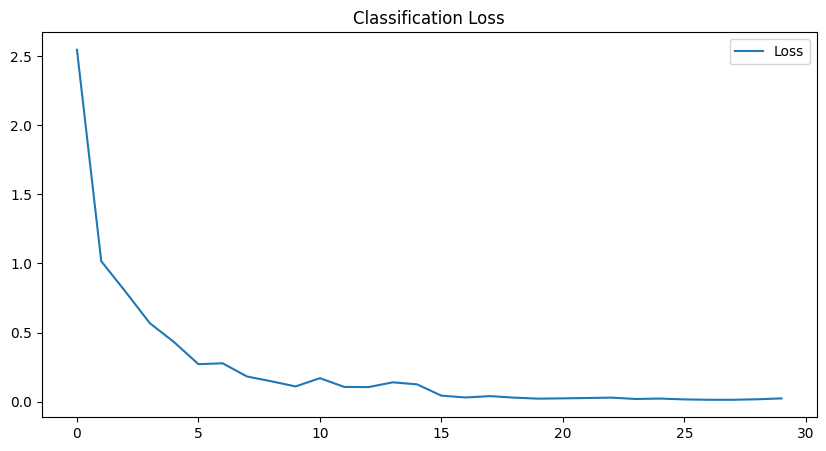

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

The graph exhibits a typical pattern seen in training machine learning models, where the loss starts high and then decreases rapidly before stabilizing at a lower level. This is a good sign, as it indicates the model is effectively learning and minimizing the classification loss during the training process.

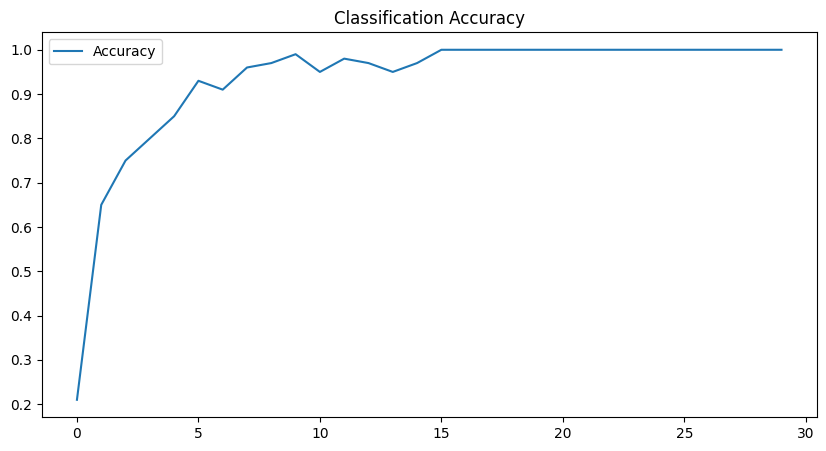

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()

In [ ]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 7ms/step - loss: 1.6905 - accuracy: 0.8500
Training Accuracy: 85.00%


In [ ]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 2s 8ms/step - loss: 1.9056 - accuracy: 0.4952
Test Accuracy: 49.52%


The test accuracy is  lower than the training accuracy and this large gap between the training and test accuracy suggests that the model is overfitting to the training data.



GAN-generated data enhances CNN performance by diversifying training datasets, improving robustness against variations, and addressing data scarcity through semi-supervised learning

Potential of GANs for Improving Image Classification Models:
GANs enhance model robustness via diverse data augmentation, facilitate semi-supervised learning by generating labeled/unlabeled data, and improve accuracy by addressing data scarcity and domain adaptation challenges.